# Simpsons Detector
## Creating dataset

The following Python notebook refers the [simpsons detector post](http://zachmoshe.com).

This notebook shows how to generate the actual training set files (while I could work directly with the generator, I finally created ~50K images and fed them to the network as static files).

Some classes are from my `general` and `simpsons` modules. They are available in [my github repo](https://github.com/zachmoshe/datalab)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import keras
import sklearn
import pickle
from sklearn.pipeline import Pipeline
import time

import sys
import logging 
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger("py.warnings").setLevel(logging.ERROR)

%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 

Using TensorFlow backend.


In [3]:
import general
import simpsons

In [4]:
config = dict(
    training_img_shape=(202,360),     # 1/4 of HD image
    network_input_shape=(202,360),         # ...
)

In [5]:
BASE_PATH = "/Users/zach/proj/datalab-data/simpsons/"

## Load the datasets

In [11]:
import gzip
import pickle

with gzip.GzipFile(BASE_PATH+"/dataset.pickle.zip", "r") as f:
    data = pickle.load(f)

print("train images by char: ", data.train.y.sum(axis=0))
print("train_dev images by char: ", data.train_dev.y.sum(axis=0))
print("dev  images by char: ", data.dev.y.sum(axis=0))
print("test images by char: ", data.test.y.sum(axis=0))
data.show()

train images by char:  [ 109.  118.   76.   49.]
train_dev images by char:  [ 36.  40.  25.  17.]
dev  images by char:  [  74.  102.   65.   63.]
test images by char:  [  73.  101.   65.   66.]
train
  - X: (663, 300, 300, 3)
  - y: (663, 4)
train_dev
  - X: (222, 300, 300, 3)
  - y: (222, 4)
dev
  - X: (351, 202, 360, 3)
  - y: (351, 4)
test
  - X: (351, 202, 360, 3)
  - y: (351, 4)


## Show some training set examples

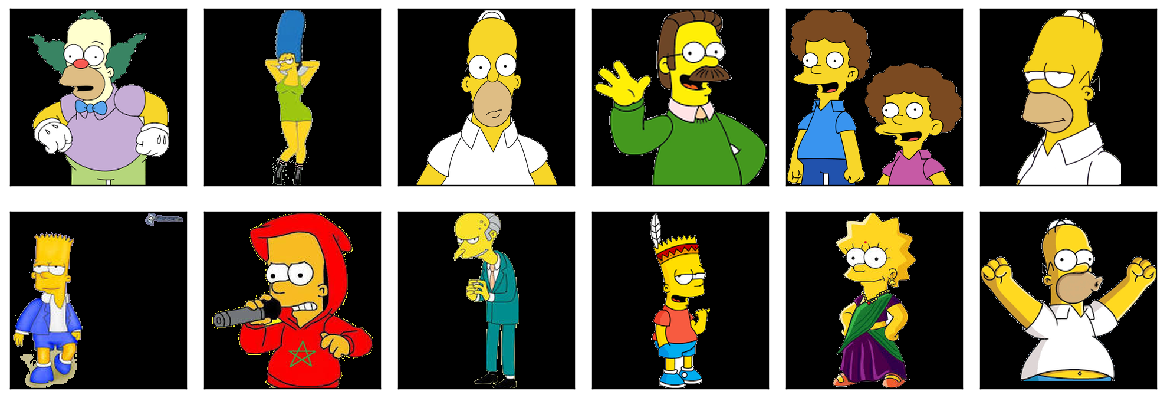

In [12]:
general.plotting.gridplot(data.train.X[:12])

I didn't want to extract background frames everytime so I used `%store` and only if it wasn't there, a full scan and parsing would happen

In [14]:
%store -r background_images
if 'background_images' not in vars(): 
    frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
        background_videoclips_path=BASE_PATH+"preprocessing/training/backgrounds",
        background_required_num=100, 
        background_output_shape=config['training_img_shape'],
    )
    background_images = frame_generator.background_images
    %store background_images    
    
    import pickle
    import gzip
    import time

    with gzip.GzipFile(BASE_PATH+"background_images.pickle.zip", 'wb') as f:
        pickle.dump(background_images, f)

Define the preprocess pipeline (same happens for generated training images and real test images).

* VGG Preprocessor - VGG network requires the RGB mean values to be subtracted from the input
* Resize - rescales the image to a given size

In [17]:
# Preprocess pipeline
simpsons_preprocess = Pipeline([
        ('vgg_preprocessor', simpsons.preprocessing.VGGPreprocessing()),
        ('resize', general.utils.ImageResizeTransformer(config['network_input_shape'])),
    ])

# simpsons frame generator
frame_generator = simpsons.preprocessing.SimpsonsFrameGenerator(
    preprocess_pipeline=simpsons_preprocess,
    background_images=background_images, 
)

## Define generator params

As was mentioned in the blog, this sets all parameters to the generator. We control how many characters (max) will be generated in every frame, ranges of rescale factor for each and general image augmentation parameters (flip, rotation)

In [8]:
TRAININGSET_FOLDER = BASE_PATH+"/trainingset"

generator_params = \
    {
        'batch_size': 1280,
        'output_shape': config['training_img_shape'],
        'max_num_characters': 3,
        'train_shape_range': [0.25,0.85],
        'aug_horizontal_flip': True,
        'aug_rotation_range': 20.,
    }

g = frame_generator.generate(data.train.X, data.train.y, **generator_params)

def generate_batch(g):
    batch_id = "{:d}".format(int(time.time()*1e7))
    gen_imgs, gen_labels = next(g)
    pickle.dump([gen_imgs, gen_labels], open(TRAININGSET_FOLDER + "/" + batch_id, "wb"))


Generate the training images batches

In [18]:
for i in range(40):
    generate_batch(g)
    print(i)

## Show generated training images vs. real frames

In [19]:
import glob

for f in np.random.permutation(glob.glob(TRAININGSET_FOLDER + "/*"))[:1]:
    %time i,l = pickle.load(open(f, "rb"))
    general.plotting.gridplot(i[-12:-1])

In [22]:
general.plotting.gridplot(data.dev.X[:12])